In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [15]:
words = open("../names.txt","r").read().splitlines()

In [16]:
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [17]:
# build chars into mapping to and from ints:
chars = ['.'] + sorted(list(set(''.join(words))))
itos = {k:v for k,v in enumerate(chars)}
stoi = {v:k for k,v in itos.items()}
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [18]:
# building the dataset

block_size = 3 # how many characters do we want to use to predict the next one

X,Y = [],[]
for word in words[:5]:
    print(word)
    context = [0] * block_size
    for chr in word + '.':
        ix = stoi[chr]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[c] for c in context), '-->', chr)
        context = context[1:] + [ix] # crop the first and add the next
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... --> e
..e --> m
.em --> m
emm --> a
mma --> .
olivia
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
ava
... --> a
..a --> v
.av --> a
ava --> .
isabella
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
sophia
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [19]:
# resulting shapes:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [20]:
# creating the lookup table - we'll create a 2d embedding for 27 character
C = torch.rand((27,2))

In [21]:
# previously we used one hot encoding
# note that need to pass a tensor into this, output is a int - cast to float()
# one-hot will use matmul to pick out the 5th row of C and is equivalent:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C == C[5]

tensor([True, True])

In [22]:
# pytorch is flexible for indexing, you can use a list or even a tensor:
C[5], C[[5,5,6]], C[torch.tensor([5,5,6])]

(tensor([0.1541, 0.6384]),
 tensor([[0.1541, 0.6384],
         [0.1541, 0.6384],
         [0.1187, 0.2019]]),
 tensor([[0.1541, 0.6384],
         [0.1541, 0.6384],
         [0.1187, 0.2019]]))

In [23]:
# you can even use a multi dimensional tensor of integers:
X.dtype, C[X].shape

(torch.int64, torch.Size([32, 3, 2]))

In [24]:
# X    -> (32, 3)
# C    -> (27, 2)
# C[X] -> (32, 3, 2) 
C[1], C[X], C[X][13,2] == C[1]

(tensor([0.3946, 0.9265]),
 tensor([[[0.9850, 0.8307],
          [0.9850, 0.8307],
          [0.9850, 0.8307]],
 
         [[0.9850, 0.8307],
          [0.9850, 0.8307],
          [0.1541, 0.6384]],
 
         [[0.9850, 0.8307],
          [0.1541, 0.6384],
          [0.3882, 0.4267]],
 
         [[0.1541, 0.6384],
          [0.3882, 0.4267],
          [0.3882, 0.4267]],
 
         [[0.3882, 0.4267],
          [0.3882, 0.4267],
          [0.3946, 0.9265]],
 
         [[0.9850, 0.8307],
          [0.9850, 0.8307],
          [0.9850, 0.8307]],
 
         [[0.9850, 0.8307],
          [0.9850, 0.8307],
          [0.8874, 0.4195]],
 
         [[0.9850, 0.8307],
          [0.8874, 0.4195],
          [0.0071, 0.3440]],
 
         [[0.8874, 0.4195],
          [0.0071, 0.3440],
          [0.4621, 0.0948]],
 
         [[0.0071, 0.3440],
          [0.4621, 0.0948],
          [0.5333, 0.4286]],
 
         [[0.4621, 0.0948],
          [0.5333, 0.4286],
          [0.4621, 0.0948]],
 
         [[0.533

In [25]:
# create the embedding, associate 2d embedding with each character in block for each training example
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [26]:
# build the hidden layer: pick 100, a hyperparameter. Weights plus bias
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [27]:
# we can't multiple matrixes together as emb -> (32, 3, 2) and W1 -> (6, 100)
# matmul only works if A is m x n, B is n x p, then for C = AB, C is m x p , n must be the same in both matrixes
# so above won't work as emb can be multiplied by W1 so must convert emb -> (32, 6)

# first way to do thi us via concat, where we pick the sequence char indexes of the block and concat on the columns (1):
torch.cat([emb[:,0,:], emb[:,1,:],emb[:,2,:]],1)

tensor([[0.9850, 0.8307, 0.9850, 0.8307, 0.9850, 0.8307],
        [0.9850, 0.8307, 0.9850, 0.8307, 0.1541, 0.6384],
        [0.9850, 0.8307, 0.1541, 0.6384, 0.3882, 0.4267],
        [0.1541, 0.6384, 0.3882, 0.4267, 0.3882, 0.4267],
        [0.3882, 0.4267, 0.3882, 0.4267, 0.3946, 0.9265],
        [0.9850, 0.8307, 0.9850, 0.8307, 0.9850, 0.8307],
        [0.9850, 0.8307, 0.9850, 0.8307, 0.8874, 0.4195],
        [0.9850, 0.8307, 0.8874, 0.4195, 0.0071, 0.3440],
        [0.8874, 0.4195, 0.0071, 0.3440, 0.4621, 0.0948],
        [0.0071, 0.3440, 0.4621, 0.0948, 0.5333, 0.4286],
        [0.4621, 0.0948, 0.5333, 0.4286, 0.4621, 0.0948],
        [0.5333, 0.4286, 0.4621, 0.0948, 0.3946, 0.9265],
        [0.9850, 0.8307, 0.9850, 0.8307, 0.9850, 0.8307],
        [0.9850, 0.8307, 0.9850, 0.8307, 0.3946, 0.9265],
        [0.9850, 0.8307, 0.3946, 0.9265, 0.5333, 0.4286],
        [0.3946, 0.9265, 0.5333, 0.4286, 0.3946, 0.9265],
        [0.9850, 0.8307, 0.9850, 0.8307, 0.9850, 0.8307],
        [0.985

In [28]:
# second option: the above would work but doesn't generalise to the block size
# instead can use torch.unbind - this removes a dimesion and returns a tuple, no data is lost
# then this can be passed into the cat function on columns to make a (32, 6) output:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])

In [29]:
# third and simpliest option is to make use of pytorch internals. data is stored continguously within the tensor 
# and we can use a view on top of the data structure to shape our tensors dimensionality, via stride properties, to do this:
emb.view(32,6) == torch.cat(torch.unbind(emb,1),1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [30]:
# so this will work matmul: (32,6) @ (6,100) -> (32,100). Also using -1 will infer what it should be.
# This is more efficient whereas cat creates a new tensor which requires more memory. 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [31]:
# need to be careful about broadcasting. In this case:
# (32,100) 
#  ( 1,100) broadcasting is aligned to right
(emb.view(-1,6) @ W1).shape, b1.shape

(torch.Size([32, 100]), torch.Size([100]))

In [32]:
# this is the hidden layer which we initalise with same number of neurons as hidden layer, output is one of 27 char values
W2 = torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2

In [33]:
logits.shape

torch.Size([32, 27])

In [34]:
# we now do the same as previously to get the probability: 
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [35]:
prob[0].sum()

tensor(1.0000)

In [36]:
# next we calculate the loss based on the training set output. We need to pull out the prob for each result.
# the results are:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [37]:
# using the natural log (ln) and mean to get the loss for the training set:  
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(13.9523)

In [38]:
# refactor the above and summarise:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [39]:
# forward pass consolidation: 
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
## replace below with cross entropy: 
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(13.9523)

In [40]:
# cross entropy can be used for classification in NNs. cross-entropy is a loss function to compare differences between two prob distributions
# the actual labels, and the predicted distribution. this is used as minimise this during training: 
F.cross_entropy(logits, Y)

tensor(13.9523)

In [41]:
# cross entropy will: 
# 1) doesn't create intermediate tensors - has kernels to do this
# 2) backward pass is much simplier to implement, a bit like tanh in micrograd
# 3) better behaved - when some logit is extreme, during optimisation. below see nan for prob when 100:

logits = torch.tensor([-100,-3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [42]:
# cross entropy fixes this by offsetting values by the maximum value. The offset doesn't impact the resulting probabilities
logits = torch.tensor([-100,-3,0,5]) - 5
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0.0000e+00, 3.3311e-04, 6.6906e-03, 9.9298e-01])

In [43]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.rand((6,100), generator=g)
b1 = torch.rand(100, generator=g)
W2 = torch.rand((100,27), generator=g)
b2 = torch.rand(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [44]:
sum(p.nelement() for p in parameters)

3481

In [45]:
for p in parameters: 
    p.requires_grad = True

In [46]:
# loss is low as we're overfitting the data
for _ in range(1000):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

0.267802357673645


In [47]:
# loss is low as we are overfitting data. but can't make loss = 0 as we have multiple options for the same input, e.g. ... > a,e,s,i or o
logits.max(1), Y

(torch.return_types.max(
 values=tensor([ 55.1669,  55.9033,  53.3494,  38.5483,  21.6247,  55.1669,  46.2224,
          47.4314,  36.1415,  43.0257,  22.0477,   3.2516,  55.1669,  49.2692,
          34.3166, -10.1395,  55.1669,  53.9260,  18.2422, -21.1448, -19.0877,
          32.4733,  50.4130,  55.6918,  50.7119,  55.1669,  37.6700,  -0.8023,
          -4.7286,  18.8418,  39.9256,  10.7085], grad_fn=<MaxBackward0>),
 indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])),
 tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
          1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [48]:
a = torch.tensor([[1,2],[3,4]])
a

tensor([[1, 2],
        [3, 4]])

In [49]:
a.max(1), a[1,0]

(torch.return_types.max(
 values=tensor([2, 4]),
 indices=tensor([1, 1])),
 tensor(3))

In [50]:
# now use full dataset: 

block_size = 3 # how many characters do we want to use to predict the next one

X,Y = [],[]
for word in words:
    context = [0] * block_size
    for chr in word + '.':
        ix = stoi[chr]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[c] for c in context), '-->', chr)
        context = context[1:] + [ix] # crop the first and add the next
X = torch.tensor(X)
Y = torch.tensor(Y)

In [51]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [52]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [53]:
sum(p.nelement() for p in parameters)

3481

In [54]:
for p in parameters:
    p.requires_grad = True

In [55]:
# this is quite slow as we're using all 228,000 examples. Instead pick a mini-batch and forward and backwards on that.
# pick the mini-batch randomly.
for _ in range(10):

    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.08448600769043
15.776532173156738
14.833340644836426
14.002605438232422
13.253263473510742
12.57991886138916
11.983102798461914
11.470495223999023
11.05185604095459


In [43]:
# create a mini batch of 32 examples from the 228,000. The following get's random indexes for the batch and returns 32 of them
torch.randint(0,X.shape[0],(32,))

tensor([ 89661,  67213, 188399,  13614,  59977,  34924, 149897,   1656, 161709,
        180002,  53632, 178869,  53254,  70218, 164374, 156845,  31384,   9101,
         21364,  20712, 136082,  49691, 181266, 152804,   4260,  85537, 106884,
         64125,  53042, 149261, 139871,   1899])

In [44]:
# using minibatches for each iteration, ix is a random index used to get 32 examples, and cross entropy Y also uses these.
# this is still useful, it's better to get the approximate gradient and take more steps than get an accurate gradient and fewer steps
for _ in range(1000):

    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

2.7047901153564453


In [45]:
# get loss for all examples, after running above for a few times
emb  = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss)


tensor(2.6808, grad_fn=<NllLossBackward0>)


In [6]:
# how do we determine the learning rate? 10 is too high, loss doesn't reduce, 0.001 is quite low and takes a long time
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [7]:
for p in parameters:
    p.requires_grad = True

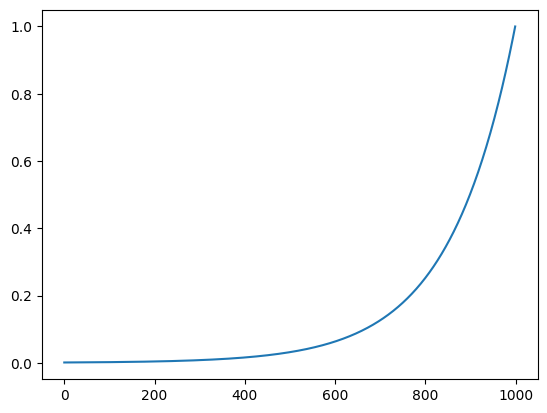

In [8]:
# learning rate is spaced exponentially
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
# print(lrs)
plt.plot(lrs)

In [26]:
# rather than use a fixed learning rate, we use a low learning rate initially and increase it as per graph above
# we capture the loss and the rate and go from the low to high (1) learning rates
lri, lossi = [],[]

for i in range(1000):

    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
print(loss.item())


11.621245384216309


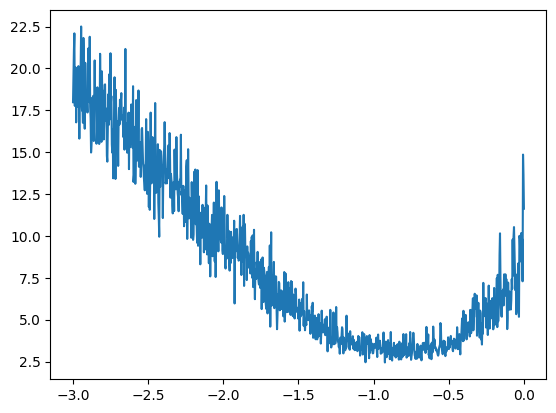

In [27]:
# prints the exponent of the learning rate against the loss. so 10**-1 = 0.1 is a good learning rate 
plt.plot(lri, lossi)

In [9]:
# now reset and use this learning rate, -0.1 (10^-1 = 0.1) and then reduce it to :
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [10]:
for p in parameters:
    p.requires_grad = True

In [11]:
# start with learning rate of 0.1 and then drop it to 0.01 (learning rate decay) after ~60,000 iterations
for _ in range(10000):

    # minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1
    # update
    for p in parameters:
        p.data += -lr * p.grad


In [13]:
# check loss: 
emb  = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss)

tensor(0.2635, grad_fn=<NllLossBackward0>)


In [56]:
# potential for overfitting, which means the loss can go to zero and works really well on the training set
# if you then evaluate the loss on a withhold set of data it be can very high
# It's best practice to split the dateset into three: training (80%), dev/validation (10%) and test split (10%).
# the training split is to optimise the parameters using gradient descent
# the dev split is used for different hyperparameter parameters such as the size of the hidden layer, the size of the embedding,  
# the regulisation strength, etc. 
# the test split is used to eval the model performance - everytime you evalulate the loss on the test set you risk overfitting to it

In [28]:
# create splits:

def build_datasets(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random

words = open("../names.txt","r").read().splitlines()

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])
Xdev, Ydev = build_datasets(words[n1:n2])
Xte, Yte = build_datasets(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [29]:
# using the training set: 
# initialise: 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [30]:
for p in parameters:
    p.requires_grad = True

In [31]:
for _ in range(30000):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.01 # run on 30000 batches with 0.1 and then 10000 batchs with 0.01
    
    # update
    for p in parameters:
        p.data += -lr * p.grad

In [32]:
print(loss.item())

2.4472105503082275


In [33]:
# check loss on dev split: 
emb  = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(2.4780, grad_fn=<NllLossBackward0>)


In [34]:
# check loss on test split:
emb  = C[Xte]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss)

tensor(2.4841, grad_fn=<NllLossBackward0>)


In [38]:
# if dev and test losses are similar (2.27) which means network is very small and can make improvements by making it bigger
# so scale up the network: 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [39]:
sum(p.nelement() for p in parameters)

10281

In [37]:
for p in parameters:
    p.requires_grad = True

In [7]:
# run again keeping track of loss and steps, using training set:

lossi, stepi = [],[]
for i in range(50000):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.01 # run on 10000 batches with 0.1 and then 10,000 batchs with 0.05-0.01

    
    # update
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss.item())

NameError: name 'Xtr' is not defined

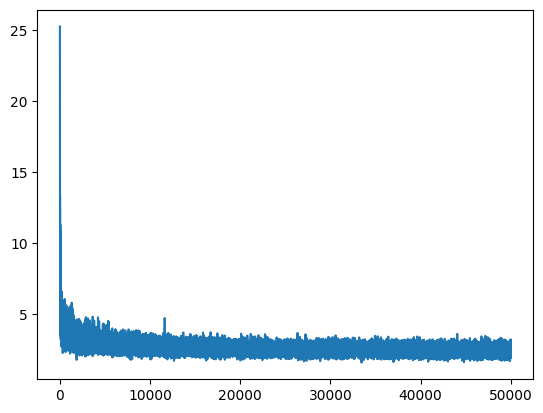

In [157]:
# noise in steps is due to the size of the mini-batch. a bigger batchsize would improve this
plt.plot(stepi,lossi)

In [162]:
# check loss on training split:
emb  = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss)

tensor(2.2326, grad_fn=<NllLossBackward0>)


In [163]:
# check loss on dev split:
emb  = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(2.2425, grad_fn=<NllLossBackward0>)


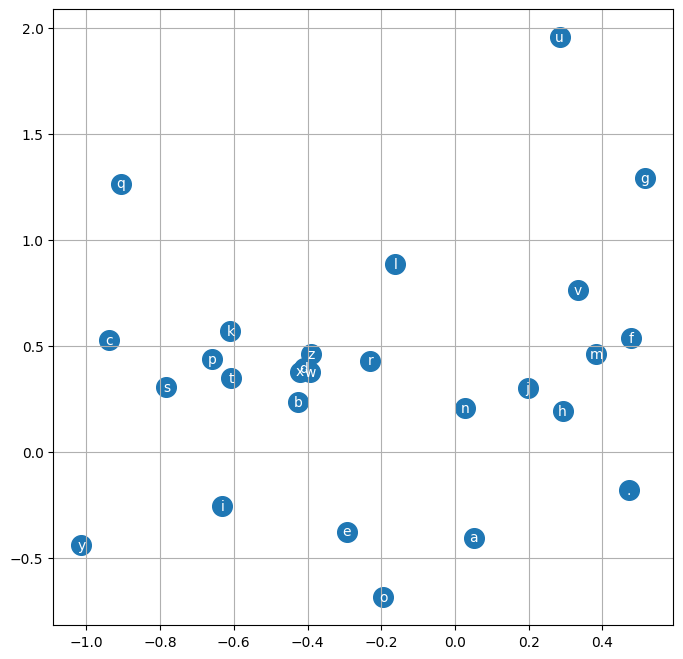

In [164]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i],ha="center", va="center", color="white")
plt.grid('minor')

In [128]:
# beat 2.17
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,12), generator=g)
W1 = torch.randn((12*3,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

# g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((27,2), generator=g)
# W1 = torch.randn((6,300), generator=g)
# b1 = torch.randn(300, generator=g)
# W2 = torch.randn((300,27), generator=g)
# b2 = torch.randn(27, generator=g)
# parameters = [C, W1, b1, W2, b2]

In [129]:
sum(p.nelement() for p in parameters)

19551

In [130]:
for p in parameters:
    p.requires_grad = True

In [131]:
stepi, lossi = [], []


In [137]:
for i in range(200_000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0],(32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 12*3) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100_000 else 0.01
    # lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

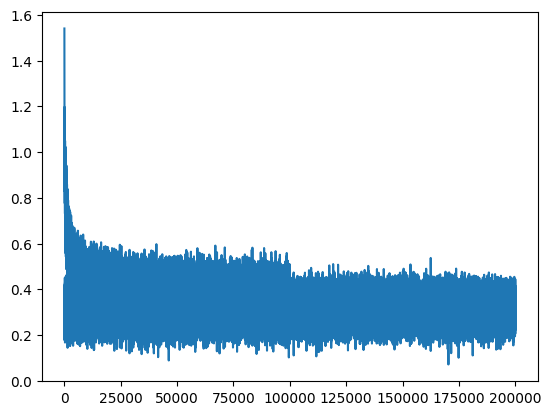

In [138]:
plt.plot(stepi, lossi)

In [139]:
# check loss on training split:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss)

tensor(2.0811, grad_fn=<NllLossBackward0>)


In [140]:
# check loss on dev split:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,36) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(2.1468, grad_fn=<NllLossBackward0>)


In [ ]:
# parameters
# 200 hidden, 30 embedding, 32 minibatch, 200_000 iterations, lr = 0.1 then 0.01 < 100_000. Loss: Tr: 2.1246, dev: 2.1654
# 300 hidden, 30 embedding, 32 minibatch, 200_000 iterations, lr = 0.1 then 0.01 < 100_000. Loss: Tr: 2.1316, dev: 2.1956
# 150 hidden, 30 embedding, 32 minibatch, 200_000 iterations, lr = 0.1 then 0.01 < 100_000. Loss: Tr: 2.1481, dev: 2.1795
# 300 hidden, 36 embedding, 32 minibatch, 200_000 iterations, lr = 0.1 then 0.01 < 100_000. Loss: Tr: 2.0984, dev: 2.1633
# another 100,000 iterations at 0.001 loss rate is better

In [150]:
# how to sample from the model: 

g = torch.Generator().manual_seed(21477483647+1)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # exponent of logits and makes it sum to 1
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample one index from probs
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

jonna.
bhant.
ansha.
hanbi.
jubrinn.
fali.
hazar.
avystyn.
haciri.
arton.
carin.
coralds.
maualhan.
isahna.
dany.
amerem.
zreegeleem.
dary.
rakiansy.
salleah.
